# 1. Preliminary EDA (getting to know the data)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.svm import SVR
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.compose import make_column_selector
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer

In [2]:
# we import bikes ones for the EDA and ones for the analysis so that any transformations we perform on
# the EDA dataset will not affect our dataset for the analysis

bikes_eda = pd.read_csv("hour.csv",  parse_dates = ["dteday"], dayfirst = True)

bikes = pd.read_csv("hour.csv",  parse_dates = ["dteday"], dayfirst = True)


## 1a. Quick look at the data

In [3]:
bikes_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17279 non-null  object        
 4   temp        17280 non-null  float64       
 5   atemp       17279 non-null  float64       
 6   hum         17279 non-null  float64       
 7   windspeed   17279 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB


In [4]:
bikes_eda.describe()

,instant,hr,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17280.000000,17279.000000,17279.000000,17279.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,11.546752,0.497071,0.475530,0.627235,0.190114,35.676218,153.786869,189.463088
std,5017.0295,6.914405,0.192474,0.171782,0.193047,0.122378,49.305030,151.357286,181.387599
min,1.0000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,6.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,12.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,18.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,23.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [5]:
bikes_eda.isna().sum()

instant         0
dteday          0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64

## 1b. Plotting distributions

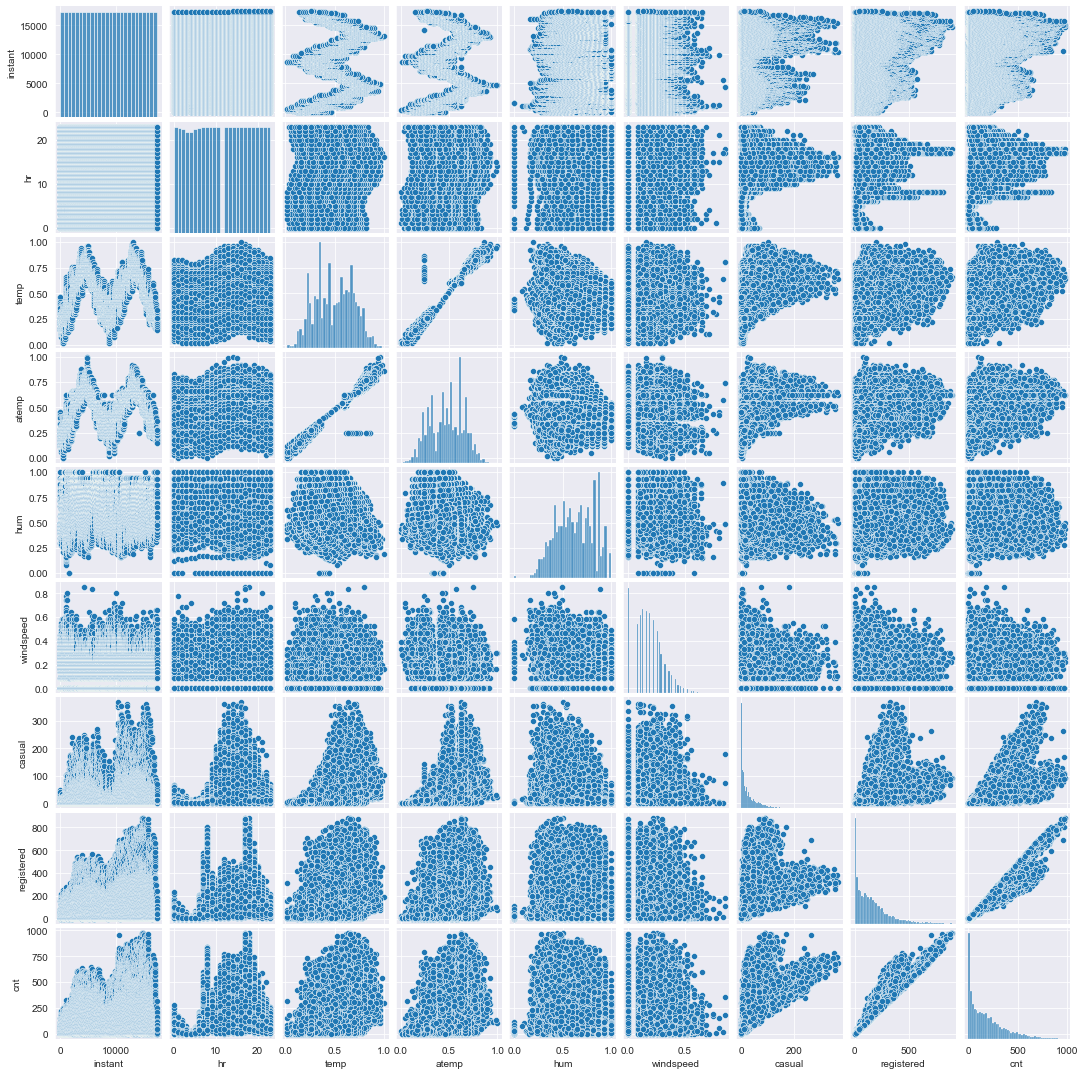

In [6]:
#sns pairplot to preview distributions
pairplot = sns.set_style('darkgrid')
pairplot = sns.pairplot(bikes_eda)

pairplot.fig.set_size_inches(15,15)

In [7]:
bikes_eda.skew()

instant       0.000000
hr           -0.010680
temp         -0.005497
atemp        -0.089988
hum          -0.110665
windspeed     0.577263
casual        2.499237
registered    1.557904
cnt           1.277412
dtype: float64

In [8]:
bikes_eda.kurt()

instant      -1.200000
hr           -1.198021
temp         -0.941440
atemp        -0.846272
hum          -0.826740
windspeed     0.596214
casual        7.571002
registered    2.750018
cnt           1.417203
dtype: float64

<AxesSubplot:>

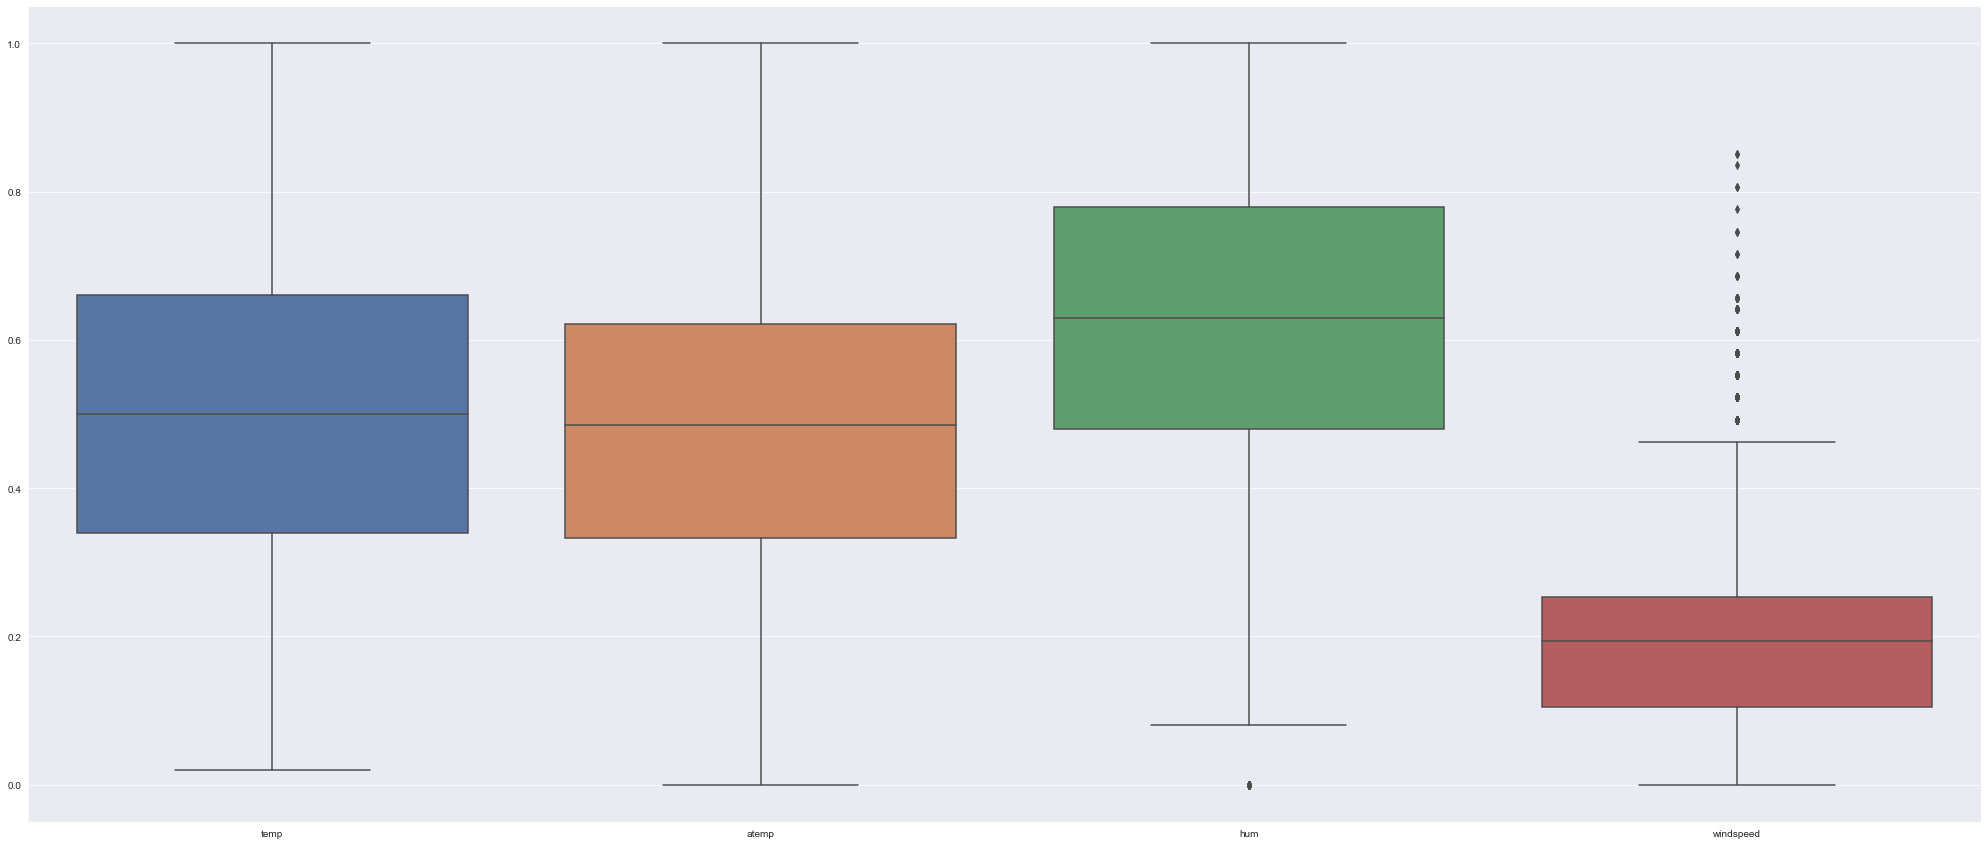

In [9]:
#  boxplots of the weather features
fig, axes = plt.subplots(1, figsize=(35, 15))
sns.set(style="whitegrid")
sns.boxplot(data = bikes_eda.iloc[:, 3:8])

### Comments 
* The box plot for the weather features shows that there are outliers in the windspeed.

<AxesSubplot:>

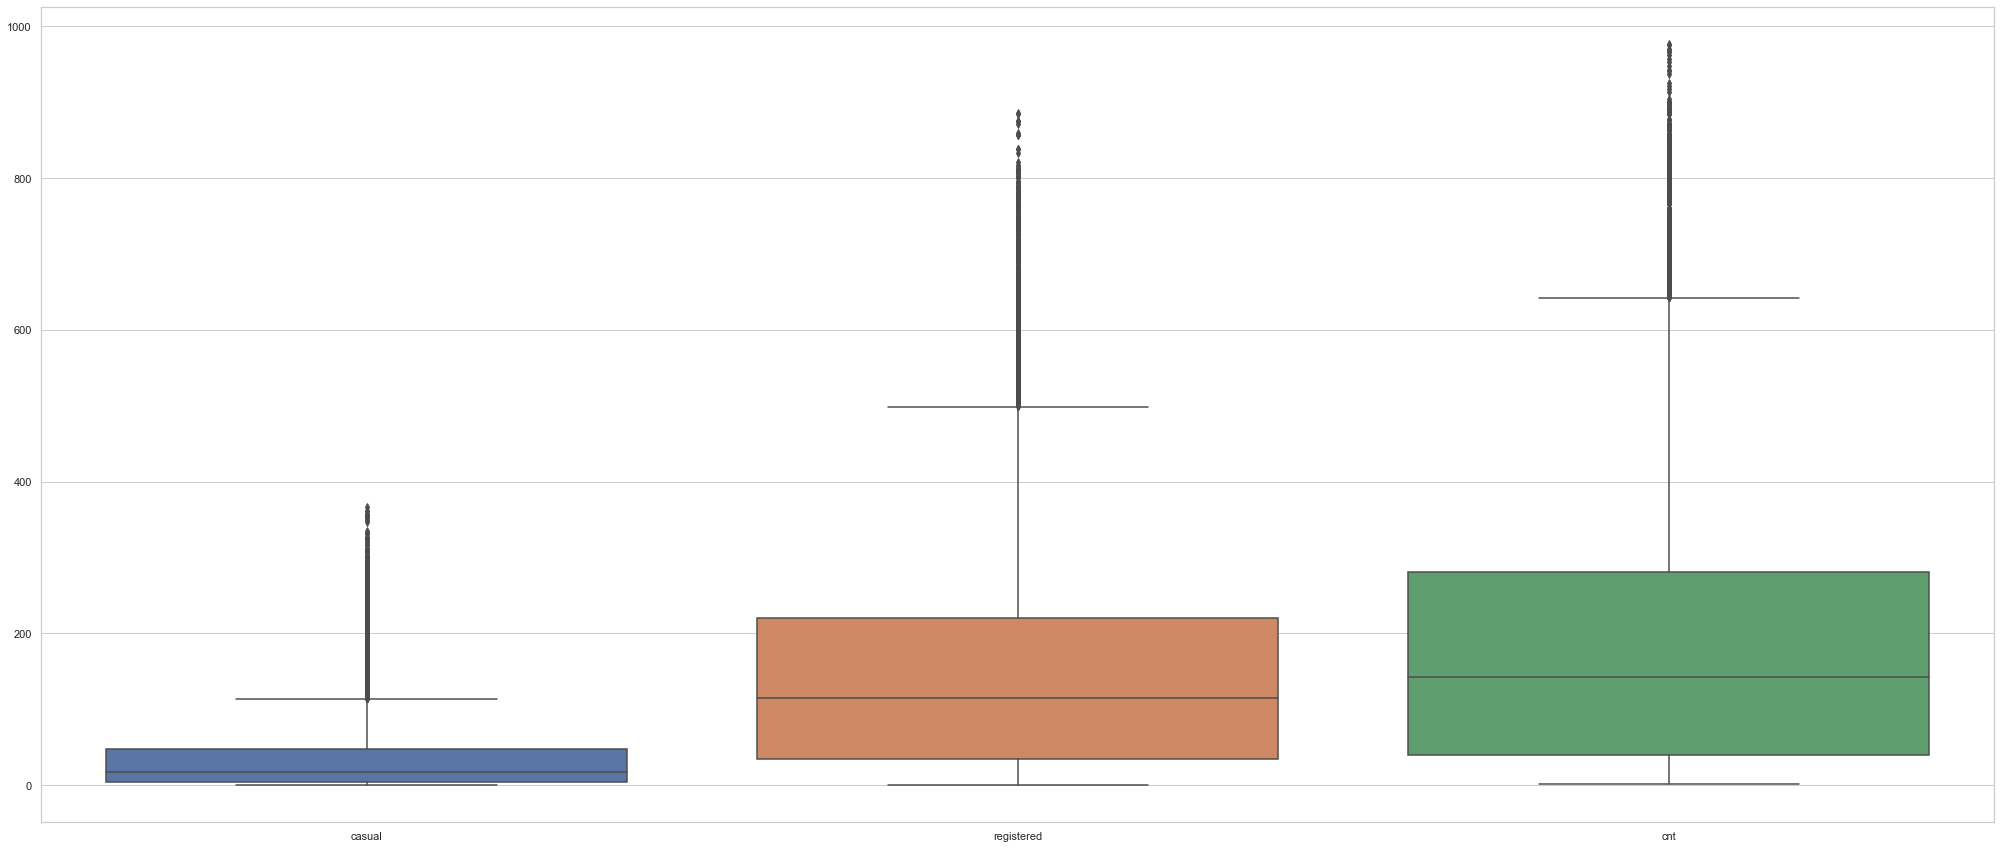

In [10]:
#  boxplots of the user features
fig, axes = plt.subplots(1, figsize=(35, 15))
sns.set(style="whitegrid")
sns.boxplot(data = bikes_eda.iloc[:, 8:12])

### Comments
* There are a lot of outliers in each of the user types.

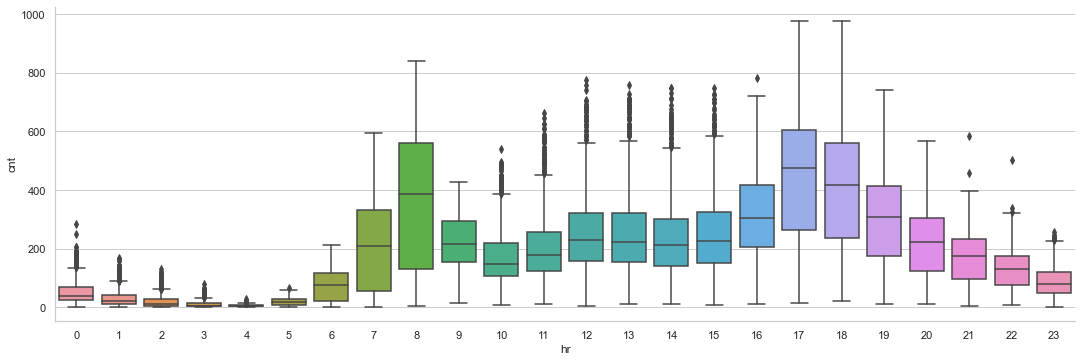

In [11]:
# checking out outliers in time and to total users
sns.catplot(x='hr',
            y='cnt', 
            kind='box', 
            data=bikes_eda,
            height=5,
            aspect=3)


### Comments
* We have many outliers when it comes to hourly number of users

## 1c. Feature creation for data analysis

In [12]:
# creating some time-related features so I can easily play around with the df based on timeframes 
bikes_eda['dteday'] = pd.to_datetime(bikes_eda.dteday, format='%Y-%m-%d')
bikes_eda["month"] = bikes_eda["dteday"].dt.month
bikes_eda["year"] = bikes_eda["dteday"].dt.year
bikes_eda['day'] = bikes_eda['dteday'].dt.day
bikes_eda["weekday"] = bikes_eda["dteday"].dt.weekday

## 1d. Correlation Matrix


In [13]:
corr = bikes_eda.corr()
corr.style.background_gradient(cmap='coolwarm', axis = None, vmin=-1, vmax=1).set_precision(2)

,instant,hr,temp,atemp,hum,windspeed,casual,registered,cnt,month,year,day,weekday
instant,1.00,-0.00,0.14,0.14,0.01,-0.07,0.16,0.28,0.28,0.49,0.87,0.05,0.00
hr,-0.00,1.00,0.14,0.13,-0.28,0.14,0.30,0.37,0.39,-0.01,-0.00,0.00,-0.00
temp,0.14,0.14,1.00,0.99,-0.07,-0.02,0.46,0.34,0.41,0.20,0.04,0.03,-0.04
atemp,0.14,0.13,0.99,1.00,-0.05,-0.06,0.45,0.33,0.40,0.21,0.04,0.02,-0.04
hum,0.01,-0.28,-0.07,-0.05,1.00,-0.29,-0.35,-0.27,-0.32,0.16,-0.08,0.03,-0.04
windspeed,-0.07,0.14,-0.02,-0.06,-0.29,1.00,0.09,0.08,0.09,-0.14,-0.01,0.01,0.00
casual,0.16,0.30,0.46,0.45,-0.35,0.09,1.00,0.51,0.69,0.07,0.14,-0.00,0.24
registered,0.28,0.37,0.34,0.33,-0.27,0.08,0.51,1.00,0.97,0.12,0.25,-0.00,-0.09
cnt,0.28,0.39,0.41,0.40,-0.32,0.09,0.69,0.97,1.00,0.12,0.25,-0.00,-0.01
month,0.49,-0.01,0.20,0.21,0.16,-0.14,0.07,0.12,0.12,1.00,-0.01,0.01,0.00


### Comments

* The count is equal to registered and casual, so we have to drop the latter ones for the data analysis. 

### Plotting highly correlated features

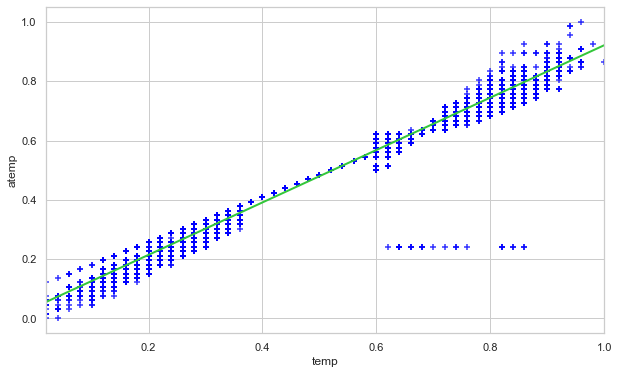

In [14]:
temp_corr = bikes_eda["temp"]
atemp_corr = bikes_eda["atemp"]
 
 
fig, ax = plt.subplots(figsize=(10, 6))
 
sns.regplot(x=temp_corr,
            y=atemp_corr,
            marker="+",
            data=bikes_eda,
            color="blue",
            truncate=True,
            scatter=True,
            scatter_kws={"s": 40},
            line_kws={"lw": 2,
                      "color" : "#33c73a"},
            robust=True,
            ci=None);


### Comments
* The visualisation above suggests that we have high correlation between temp and atemp.
* We know for later that we need to drop one of them later.


## 1e. Data Visualization

### Plotting the total hourly users per type of user
* Useful for spotting those hours of the day with the highest demand of bike retals

Text(0.5, 1.0, 'Total users per hour per type of user (Washington DC: Jan 2011 - Dec 2012)')

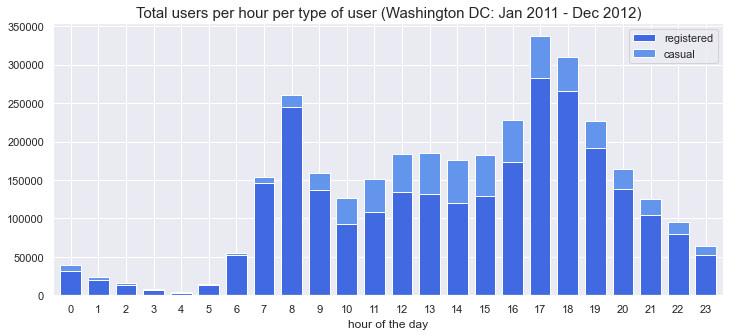

In [15]:
sns.set_style('darkgrid')

# retrieving avg user per month and per type of user
total_users_per_hour_by_user = bikes_eda.groupby('hr')[['registered', 'casual']].sum()

sns.set(rc={'figure.figsize':(12,5)})

total_users_per_hour_by_user.plot(kind='bar', 
                                  width=0.75, 
                                  stacked=True, 
                                  color=['royalblue', 'cornflowerblue'])

plt.xlabel('hour of the day')
plt.xticks(rotation = 0)
plt.title("Total users per hour per type of user (Washington DC: Jan 2011 - Dec 2012)", fontsize = 15)

### Plotting total users per day of the week per type of user
#### Are there any patterns related to the ratio of casual to registered users and the days of the week?

Text(0.5, 1.0, 'Total users users per day of the week per type of user (Washington DC: Jan 2011 - Dec 2012)')

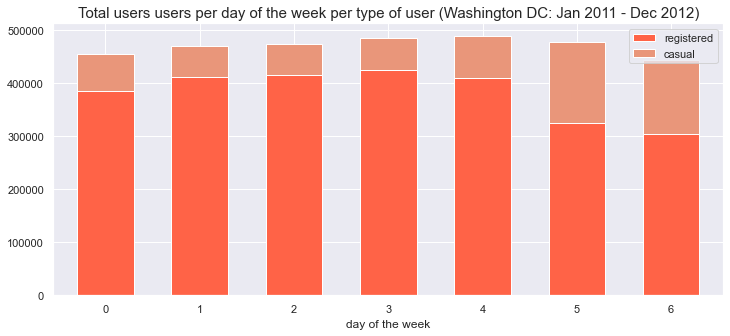

In [16]:
sns.set_style('darkgrid')

# retrieving avg user per month and per type of user
avg_users_per_hour_by_user = bikes_eda.groupby('weekday')[['registered', 'casual']].sum()

sns.set(rc={'figure.figsize':(12,5)})

avg_users_per_hour_by_user.plot(kind='bar',
                                width=0.6,
                                stacked=True, 
                                color=['tomato', 'darksalmon'])

plt.xlabel('day of the week')
plt.xticks(rotation = 0)
plt.title("Total users users per day of the week per type of user (Washington DC: Jan 2011 - Dec 2012)", fontsize = 15)

#### Comments
* Seems like casual users prefer to ride during the weekends

### Plotting total monthly users
* Useful for checking out any patterns related to the bike demand per month
* Think about the location of this case: how cold are the coldest months? Are these temperatures/weather conditions optimal for using bikes?

Text(0.5, 1.0, 'Total users per month per type of user')

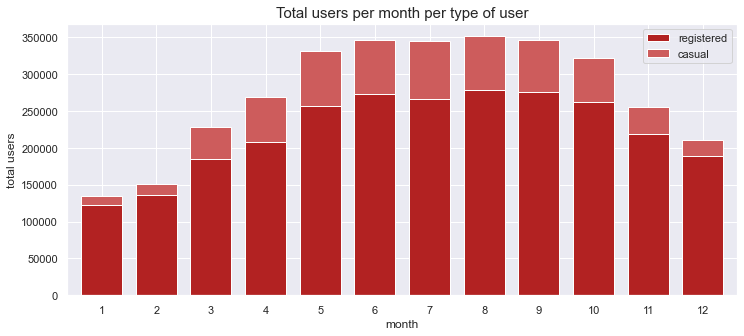

In [17]:
sns.set_style('darkgrid')

#retrieving total users per month per type of user
total_users_per_month = bikes_eda.groupby('month')[['registered', 'casual']].sum()

ax = total_users_per_month.plot(kind='bar',
                           width=0.75,
                           stacked=True, 
                           color=['firebrick', 'indianred'])

ax.set(xlabel='month', ylabel='total users')
plt.xticks(rotation = 0)
plt.title("Total users per month per type of user", fontsize = 15)

#### Comments
* is it safe to assume that bike rental demand follows a pattern related to the change between warmer and colder months?

### Plotting the monthly demand of bike rentals to look for patterns
* We already noticed less bike usage in colder months, does this pattern hold out across the whole data set? Let's check plotting a time series line plot

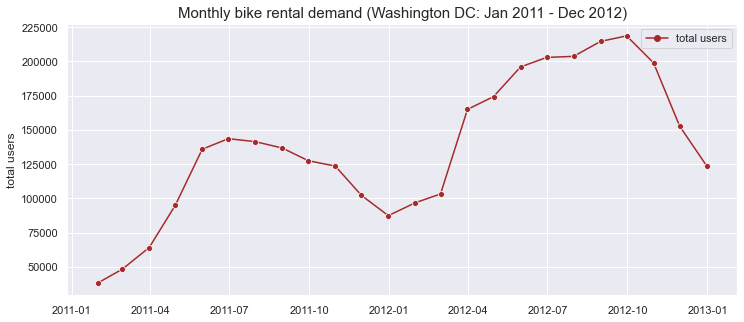

In [18]:
#grouping by monthly users across the whole dataset
monthly_demand = bikes_eda.groupby(pd.Grouper(key='dteday',freq='M')).agg({'cnt':'sum'})

#changing column name for better graph display
monthly_demand.columns = monthly_demand.columns.str.replace('cnt', 'total users')

#setting the plot style
sns.set_style('darkgrid')

#plotting
ax = sns.lineplot(data=monthly_demand, 
                  markers="o", 
                  palette=['brown'], 
                  linewidth=1.5)

ax.set(xlabel='', ylabel='total users')
plt.title('Monthly bike rental demand (Washington DC: Jan 2011 - Dec 2012)', 
          fontsize = 15)

plt.show()

#### Comments
* Here we can see a clear pattern: people prefer to ride their bikes in months of good weather
* I'm even inclined to say that this data exhibits some seasonality

# Modeling

In [19]:
# import the dataset
bikes = bikes.drop(columns=["instant", "casual", "registered"])

In [20]:
bikes.dtypes

dteday        datetime64[ns]
hr                     int64
weathersit            object
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
dtype: object

In [21]:
# split into x and y and then into train and test (+ num/cat features)

y = bikes["cnt"]
x = bikes.drop(columns=["cnt", "dteday"])

# let's first separate features
weather_features = list(x.select_dtypes(include=["object"]).columns)
numerical_features = list(x.select_dtypes(include=["float64", "int64"]).columns)

print(len(weather_features)+len(numerical_features))
print(len(x.columns))

6
6


In [22]:
# Define categorical pipeline
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])


# Fit column transformer to training data
preprocessor = ColumnTransformer([
    ("cat", cat_pipe, weather_features),
    ("num", num_pipe, numerical_features)
])

preprocessor.fit(x)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['weathersit']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['hr', 'temp', 'atemp', 'hum', 'windspeed'])])

In [23]:
# transformed dataframe
x_preprocessed = pd.DataFrame(preprocessor.transform(x))

x_preprocessed_df = pd.concat((x_preprocessed, y), axis = 1)


In [24]:
# splitting the dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/8, random_state=0, shuffle=False)

In [25]:
# Fit a pipeline with transformers and an estimator to the training data
LinearRegressionPipe = Pipeline([
    ("preprocessor", preprocessor),
    ("LinearRegression", LinearRegression())    
])

RandomForestPipe = Pipeline([
    ("preprocessor", preprocessor),
    ("RandomForestRegressor", RandomForestRegressor(random_state = 0))
])

RidgeRegressionPipe = Pipeline([
    ("preprocessor", preprocessor),
    ("Ridge", Ridge())
])

LassoRegressionPipe = Pipeline([
    ("preprocessor", preprocessor),
    ("Lasso", Lasso())
])

ElasticNetPipe = Pipeline([
    ("preprocessor", preprocessor),
    ("ElasticNet", ElasticNet(l1_ratio=0.9, max_iter=3000))
])

DecisionTreeRegressorPipe = Pipeline([
    ("preprocessor", preprocessor),
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=0))
])

In [26]:
# add the different pipelines to a list
pipelines = [LinearRegressionPipe, RandomForestPipe, RidgeRegressionPipe, LassoRegressionPipe, ElasticNetPipe, DecisionTreeRegressorPipe]
pipelines_names = ["LinearRegression", "RandomForest", "RidgeRegression", "LassoRegression", "ElasticNet", "DecisionTreeRegressorPipe"]

In [27]:
baseline_model_scores = []

for pipe, pipe_name in zip(pipelines, pipelines_names):
    pipe.fit(x_train, y_train)
    y_hat = pipe.predict(x_test)
    R_squared = r2_score(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)
    baseline_model_scores.append({
        "model" : pipe_name,
        "R-squared" : R_squared,
        "MSE": mse
    })
baseline_model_scores
baseline_model_scores_df = pd.DataFrame(baseline_model_scores, columns = ["model", "R-squared"]).set_index("model").sort_values(by = ["R-squared"], ascending = False)
baseline_model_scores_df  

,R-squared
model,
RandomForest,0.484561
DecisionTreeRegressorPipe,0.295300
ElasticNet,0.143464
RidgeRegression,0.142662
LinearRegression,0.142470
LassoRegression,0.141994


## Feature engineering

In [28]:
# first of all, we create two dummy variable to capture whether it is a weekend and whether it is during commute 
# the commute lasts between 7- and 9 AM and 5- and 7PM

bikes_eng = bikes.copy()

bikes_eng["month"] = bikes_eng["dteday"].dt.month
bikes_eng["weekday"] = bikes_eng["dteday"].dt.weekday
bikes_eng["day"] = bikes_eng["dteday"].dt.day
bikes_eng["week"] = bikes_eng["dteday"].dt.weekofyear

bikes_eng["weekend"] = bikes_eng["weekday"].map(lambda x: 1*(x>4))
bikes_eng['commute']= np.where((bikes_eng['hr'].isin([7, 8, 9, 17, 18, 19])),1,0)

#then we create two categorical features for the time of the day and the season
bikes_eng["day_period"] = pd.cut(bikes_eng["hr"], bins=[0, 6, 14, 18, 24], include_lowest=True, labels=["Night", "Morning", "Afternoon", "Evening"])
bikes_eng.loc[(bikes_eng['month'] == 12) | (bikes_eng['month'] == 1) | (bikes_eng['month'] == 2), 'season'] = 'winter'
bikes_eng.loc[(bikes_eng['month'] > 2) & (bikes_eng['month'] < 6), 'season'] = 'spring'
bikes_eng.loc[(bikes_eng['month'] > 5) & (bikes_eng['month'] < 9), 'season'] = 'summer'
bikes_eng.loc[(bikes_eng['month'] > 8) & (bikes_eng['month'] <12), 'season'] = 'autumn'

# import the holidays
cal = calendar()
holidays = cal.holidays(start=bikes_eng['dteday'].min(), end=bikes_eng['dteday'].max())
bikes_eng["holiday"] = bikes_eng["dteday"].isin(holidays).astype(int)

<ipython-input-28-2f7e2c2a12ad>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  bikes_eng["week"] = bikes_eng["dteday"].dt.weekofyear


In [29]:
corr = bikes_eng.corr()
corr.style.background_gradient(cmap='coolwarm', axis = None, vmin=-1, vmax=1).set_precision(2)

,hr,temp,atemp,hum,windspeed,cnt,month,weekday,day,week,weekend,commute,holiday
hr,1.00,0.14,0.13,-0.28,0.14,0.39,-0.01,-0.00,0.00,-0.01,-0.00,0.12,0.00
temp,0.14,1.00,0.99,-0.07,-0.02,0.41,0.20,-0.04,0.03,0.20,-0.05,0.01,-0.03
atemp,0.13,0.99,1.00,-0.05,-0.06,0.40,0.21,-0.04,0.02,0.21,-0.04,0.00,-0.04
hum,-0.28,-0.07,-0.05,1.00,-0.29,-0.32,0.16,-0.04,0.03,0.17,-0.01,-0.02,-0.01
windspeed,0.14,-0.02,-0.06,-0.29,1.00,0.09,-0.14,0.00,0.01,-0.13,0.01,0.05,-0.01
cnt,0.39,0.41,0.40,-0.32,0.09,1.00,0.12,-0.01,-0.00,0.11,-0.02,0.45,-0.03
month,-0.01,0.20,0.21,0.16,-0.14,0.12,1.00,0.00,0.01,0.97,-0.00,-0.00,0.03
weekday,-0.00,-0.04,-0.04,-0.04,0.00,-0.01,0.00,1.00,-0.01,0.01,0.79,-0.00,-0.19
day,0.00,0.03,0.02,0.03,0.01,-0.00,0.01,-0.01,1.00,0.06,-0.01,0.00,-0.01
week,-0.01,0.20,0.21,0.17,-0.13,0.11,0.97,0.01,0.06,1.00,0.01,-0.00,0.03


## Distribution of total users based on season of the year

Text(0.5, 1.0, 'Distribution of total riders by commute/no commute')

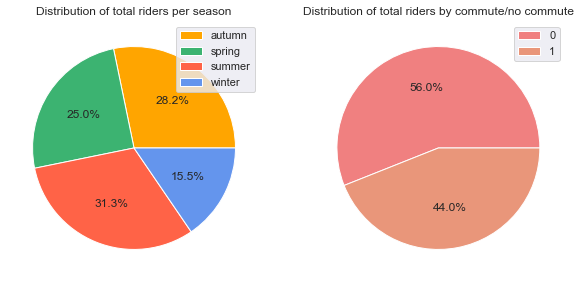

In [30]:
# extracting proportion of riders by season
users_per_seasons = bikes_eng.groupby('season')[['cnt']].mean()
x_seasons = users_per_seasons['cnt']

# extracting proportion of riders based on commuting hours
commute = bikes_eng.groupby('commute')[['cnt']].sum()
x_commute = commute['cnt']


#plotting pie charts
fig = plt.figure(figsize=(10,10))

#setting up labels and colors
colors1 = ['orange','mediumseagreen', 'tomato', 'cornflowerblue']
labels1 = labels = users_per_seasons.index

colors2 = ['lightcoral','darksalmon']
labels2 = x_commute.index

#first row, first column
ax1 = plt.subplot2grid((1,2),(0,0))
plt.pie(x_seasons, autopct='%1.1f%%', colors=colors1)
plt.legend(labels=labels1)
plt.title('Distribution of total riders per season', fontsize=12)

#first row sec column
ax1 = plt.subplot2grid((1,2), (0, 1))
plt.pie(x_commute, autopct='%1.1f%%', colors=colors2)
plt.legend(labels=labels2)
plt.title('Distribution of total riders by commute/no commute', fontsize=12)

#### Comments
* The summer the season with the highest volume of users, could the tourists than come visit the city fill the demand of those Washington DC inhabitants that travel abroad for the summer?
* Bike riders that are identifed as commuters take up a big proportion of the total bike users across the whole dataset* Bike riders that are identifed as commuters take up a big proportion of the total bike users across the whole dataset

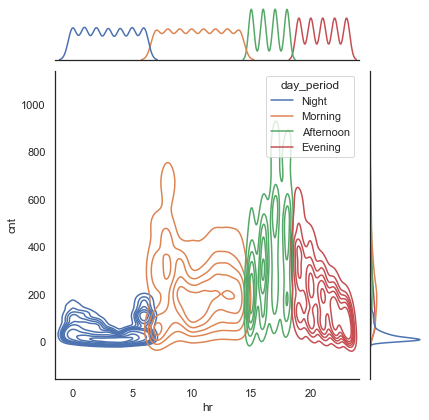

In [31]:
sns.set_style('white')
ax =sns.jointplot(
        data=bikes_eng, 
        x="hr", 
        y="cnt", 
        hue="day_period", 
        kind="kde",
        height=6,       
)


#### Comments
* The vizualisation shows that there are more users in the morning and afternoon. 
* We may suggest that there is a "rush-hour" when people go to or return from work. 
* Also the graph shows that there is an accumlation in the night time around 0 users.

## Distribution of total users in the day based on if it is a holiday or not

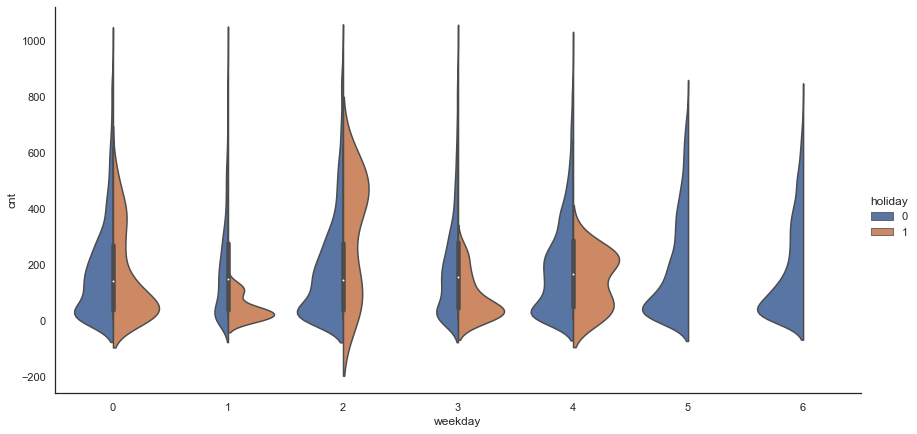

In [32]:
sns.catplot(x="weekday",
            y="cnt",
            hue="holiday",
            kind="violin",
            split=True,
            data=bikes_eng, 
            height=6,
            aspect=2)

#### Comments
* This graph may suggest that on holidays less users are taking the bike.
* That underlines our interpretation from the previous graph, as there is no rush-hour to get to work.

## Feat. Eng. Models

In [33]:
# split into x and y
# we drop temp because of high correlation with atemp (feeling temp more important)
# we cannot add both weekend and weekday due to their high correlation
# we cannot add both week and month due to their high correlation

y = np.log(bikes_eng["cnt"])
x = bikes_eng.drop(columns=["cnt", "temp", "weekday", "dteday", "week"])

# we separate features
categorical_features = ["weathersit"]
time_features = ["weekend", "hr", "month", "day", "season", "day_period", "holiday", "commute"]
weather_features = list(set(x.columns) - set(categorical_features) - set(time_features))


print(len(categorical_features), len(time_features), len(weather_features))

1 8 3


In [34]:
# here we create the general pipeline we can use for all algortihms, while later we could customize the pipeline to specific
# algortihms such as Random Forest Regressor where scaling is not so important

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

time_pipe = Pipeline([
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("imputer", SimpleImputer(strategy="median"))
])

# Fit column transformer to training data
preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("num", num_pipe, weather_features), 
    ("time", time_pipe, time_features),
    
])

preprocessor.fit(x)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['weathersit']),
                                ('num',
                                 Pipeline(steps=[('scaler', RobustScaler()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['windspeed', 'hum', 'atemp']),
                                ('time',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
    

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/8, random_state=42, shuffle=False)

In [36]:
LinearRegressionPipe = Pipeline([
    ("preprocessor", preprocessor),
    ("LinearRegression", LinearRegression())    
])

RandomForestPipe = Pipeline([
    ("preprocessor", preprocessor),
    ("RandomForestRegressor", RandomForestRegressor(random_state = 0))
])

RidgeRegressionPipe = Pipeline([
    ("preprocessor", preprocessor),
    ("Ridge", Ridge())
])

LassoRegressionPipe = Pipeline([
    ("preprocessor", preprocessor),
    ("Lasso", Lasso())
])

ElasticNetPipe = Pipeline([
    ("preprocessor", preprocessor),
    ("ElasticNet", ElasticNet(l1_ratio=0.9, max_iter=3000))
])

DecisionTreeRegressorPipe = Pipeline([
    ("preprocessor", preprocessor),
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=0))
])

In [37]:
pipelines = [LinearRegressionPipe, RandomForestPipe, RidgeRegressionPipe, LassoRegressionPipe, ElasticNetPipe, DecisionTreeRegressorPipe]
pipelines_names = ["LinearRegression", "RandomForest", "RidgeRegression", "LassoRegression", "ElasticNet", "DecisionTreeRegressorPipe"]

In [38]:
feature_eng_model_scores = []

for pipe, pipe_name in zip(pipelines, pipelines_names):
    pipe.fit(x_train, y_train)
    y_hat = pipe.predict(x_test)
    R_squared = r2_score(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)

    feature_eng_model_scores.append({
        "model" : pipe_name,
        "R-squared" : R_squared,
        "MSE": mse
    })
feature_eng_model_scores
feature_eng_model_scores_df = pd.DataFrame(feature_eng_model_scores, columns = ["model", "R-squared"]).set_index("model").sort_values(by = ["R-squared"], ascending = False)
feature_eng_model_scores_df

,R-squared
model,
RandomForest,0.822064
LinearRegression,0.727075
RidgeRegression,0.717232
DecisionTreeRegressorPipe,0.704258
LassoRegression,-0.016242
ElasticNet,-0.016242


### Comments
* We drop Lasso and Elastic Net due to their poor R2

## Scaled Models

In [39]:
# we create several preprocessors to run through the pipeline

# Define categorical pipeline and time pipeline, these ones will be the same across the different scaled pipelines
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

time_pipe = Pipeline([
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])


# -----------------------------------------------------------------------
# robust scaled numerical features

# Define numerical pipeline
robust_num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

# Fit column transformer to training data
robust_preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("time", time_pipe, time_features),
    ("num", robust_num_pipe, weather_features)
])

# -----------------------------------------------------------------------
# min_max scaled numerical features

# Define numerical pipeline
min_max_num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

# Fit column transformer to training data
min_max_preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("time", time_pipe, time_features),
    ("num", min_max_num_pipe, weather_features)
])

# --------------------------------------------------------------------------
# standard scaled numerical features


# Define numerical pipeline
standard_num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Fit column transformer to training data
standard_preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("time", time_pipe, time_features),
    ("num", standard_num_pipe, weather_features)
])

# -----------------------------------------------------------------------
# robust_pt scaled numerical features

# Define numerical pipeline
robust_pt_num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler()),
    ("transformer", PowerTransformer())
])

# Fit column transformer to training data
robust_pt_preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("time", time_pipe, time_features),
    ("num", robust_pt_num_pipe, weather_features)
])

# --------------------------------------------------------------------------
# min_max_pt scaled numerical features

# Define numerical pipeline
min_max_pt_num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler()),
    ("transformer", PowerTransformer())
])


# Fit column transformer to training data
min_max_pt_preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("time", time_pipe, time_features),
    ("num", min_max_pt_num_pipe, weather_features)
])

# --------------------------------------------------------------------------
# standard_pt scaled numerical features

# Define numerical pipeline
standard_pt_num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("transformer", PowerTransformer())
])

# Fit column transformer to training data
standard_pt_preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("time", time_pipe, time_features),
    ("num", standard_pt_num_pipe, weather_features)
])

In [40]:
preprocessors = [robust_preprocessor, min_max_preprocessor, standard_preprocessor, robust_pt_preprocessor, min_max_pt_preprocessor, standard_pt_preprocessor]
preprocessors_names = ["robust_preprocessor", "min_max_preprocessor", "standard_preprocessor", "robust_pt_preprocessor", "min_max_pt_preprocessor", "standard_pt_preprocessor"]
preprocessors_dict = dict(zip(preprocessors_names, preprocessors))

In [41]:
model = []
scaled_lr_model_scores = []

for preprocessor_name, preprocessor in preprocessors_dict.items():
    
    #Setting preprocessor and random forest model in a pipeline
    lr_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("Linear Regression scaled", LinearRegression())
            ])
    #Fitting pipeline to training data 
    model = lr_pipe.fit(x_train, y_train)

    #Predicting on X_test data
    y_hat = model.predict(x_test)
    
    #Evaluating model with classification report and confusion matrix
    R_squared = r2_score(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)
    scaled_lr_model_scores.append({
        "Linear Regression scaled" : preprocessor_name,
        "R-squared" : R_squared,
        "MSE": mse
    })
scaled_lr_model_scores
scaled_lr_model_scores_df = pd.DataFrame(scaled_lr_model_scores).set_index("Linear Regression scaled").sort_values(by = ["R-squared"], ascending = False)
scaled_lr_model_scores_df

,R-squared,MSE
Linear Regression scaled,,
standard_preprocessor,0.720923,0.601734
standard_pt_preprocessor,0.718497,0.606963
robust_preprocessor,0.717798,0.608471
robust_pt_preprocessor,0.717236,0.609684
min_max_pt_preprocessor,0.716798,0.610628
min_max_preprocessor,0.712275,0.620380


In [42]:
model = []
scaled_rf_model_scores = []

for preprocessor_name, preprocessor in preprocessors_dict.items():
    
    #Setting preprocessor and random forest model in a pipeline
    rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("Linear Regression scaled", RandomForestRegressor())
            ])
    #Fitting pipeline to training data 
    model = rf_pipe.fit(x_train, y_train)

    #Predicting on X_test data
    y_hat = model.predict(x_test)
    
    #Evaluating model with classification report and confusion matrix
    R_squared = r2_score(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)

    scaled_rf_model_scores.append({
        "Random Forest scaled" : preprocessor_name,
        "R-squared" : R_squared,
        "MSE": mse
    })
scaled_rf_model_scores
scaled_rf_model_scores_df = pd.DataFrame(scaled_rf_model_scores).set_index("Random Forest scaled").sort_values(by = ["R-squared"], ascending = False)
scaled_rf_model_scores_df
        

,R-squared,MSE
Random Forest scaled,,
standard_pt_preprocessor,0.826132,0.374887
standard_preprocessor,0.823917,0.379662
min_max_preprocessor,0.822359,0.383022
min_max_pt_preprocessor,0.821551,0.384764
robust_preprocessor,0.821464,0.384952
robust_pt_preprocessor,0.821198,0.385526


In [43]:
model = []
scaled_ridge_model_scores = []

for preprocessor_name, preprocessor in preprocessors_dict.items():
    
    #Setting preprocessor and random forest model in a pipeline
    ridge_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("Ridge scaled", Ridge())
            ])
    #Fitting pipeline to training data 
    model = ridge_pipe.fit(x_train, y_train)

    #Predicting on X_test data
    y_hat = model.predict(x_test)
    
    #Evaluating model with classification report and confusion matrix
    R_squared = r2_score(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)

    scaled_ridge_model_scores.append({
        "Ridge scaled" : preprocessor_name,
        "R-squared" : R_squared,
        "MSE": mse
    })
scaled_ridge_model_scores
scaled_ridge_model_scores_df = pd.DataFrame(scaled_ridge_model_scores).set_index("Ridge scaled").sort_values(by = ["R-squared"], ascending = False)
scaled_ridge_model_scores_df

,R-squared,MSE
Ridge scaled,,
standard_preprocessor,0.717234,0.609687
robust_preprocessor,0.717232,0.609691
min_max_preprocessor,0.717199,0.609762
min_max_pt_preprocessor,0.716285,0.611734
standard_pt_preprocessor,0.716117,0.612095
robust_pt_preprocessor,0.716102,0.612128


In [44]:
model = []
scaled_dt_model_scores = []

for preprocessor_name, preprocessor in preprocessors_dict.items():
    
    #Setting preprocessor and random forest model in a pipeline
    dt_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("Decision Trees scaled", LinearRegression())
            ])
    #Fitting pipeline to training data 
    model = dt_pipe.fit(x_train, y_train)

    #Predicting on X_test data
    y_hat = model.predict(x_test)
    
    #Evaluating model with classification report and confusion matrix
    R_squared = r2_score(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)
    scaled_dt_model_scores.append({
        "Decision Trees scaled" : preprocessor_name,
        "R-squared" : R_squared,
        "MSE": mse
    })
scaled_dt_model_scores
scaled_dt_model_scores_df = pd.DataFrame(scaled_dt_model_scores).set_index("Decision Trees scaled").sort_values(by = ["R-squared"], ascending = False)
scaled_dt_model_scores_df

,R-squared,MSE
Decision Trees scaled,,
standard_preprocessor,0.720923,0.601734
standard_pt_preprocessor,0.718497,0.606963
robust_preprocessor,0.717798,0.608471
robust_pt_preprocessor,0.717236,0.609684
min_max_pt_preprocessor,0.716798,0.610628
min_max_preprocessor,0.712275,0.620380


### Comments

* We conclude that the model does not need scalers.

## Final Model

In [45]:
# split into x and y
# we drop temp because of high correlation with atemp (feeling temp more important)
# we cannot add both weekend and weekday due to their high correlation
# we cannot add both week and month due to their high correlation
y = np.log(bikes_eng["cnt"])
x = bikes_eng.drop(columns=["cnt", "temp", "weekday", "dteday", "week"])

# we separate features
categorical_features = ["weathersit"]
time_features = ["weekend", "hr", "month", "day", "season", "day_period", "holiday", "commute"]
weather_features = list(set(x.columns) - set(categorical_features) - set(time_features))

print(len(categorical_features), len(time_features), len(weather_features))

1 8 3


In [46]:
# we attempt to create Polynomial Features and then perform PCA on those newly created ones
# this allows us to capture explanatory power of the interaction between features or the features squared 
# we use a Robust Scaler as this performs the best on Random Forest

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

time_pipe = Pipeline([
    ("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("imputer", SimpleImputer(strategy="median")),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('pca', PCA(n_components=6))
])

# Fit column transformer to training data
preprocessor = ColumnTransformer([
    ("cat", cat_pipe, categorical_features),
    ("num", num_pipe, make_column_selector(dtype_include = "number")), # was weather_features
    ("time", time_pipe, time_features),
    
])

preprocessor.fit(x)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['weathersit']),
                                ('num',
                                 Pipeline(steps=[('scaler', RobustScaler()),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False)),
                                  

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/8, random_state=42, shuffle=False)

In [48]:
rf = Pipeline([
    ("preprocessor", preprocessor),
    ("RandomForestRegressor", RandomForestRegressor(random_state = 0))
])

rf.fit(x_train, y_train)
y_hat = rf.predict(x_test)
final_model = r2_score(y_test,y_hat)
final_mse = mean_squared_error(y_test, y_hat)
print(f"R^2 score: {final_model}")
print(f"mse: {final_mse}")

R^2 score: 0.8548530867054676
mse: 0.31295934610277415


# Grid Search

In [49]:
sorted(RandomForestPipe.get_params().keys())

['RandomForestRegressor',
 'RandomForestRegressor__bootstrap',
 'RandomForestRegressor__ccp_alpha',
 'RandomForestRegressor__criterion',
 'RandomForestRegressor__max_depth',
 'RandomForestRegressor__max_features',
 'RandomForestRegressor__max_leaf_nodes',
 'RandomForestRegressor__max_samples',
 'RandomForestRegressor__min_impurity_decrease',
 'RandomForestRegressor__min_impurity_split',
 'RandomForestRegressor__min_samples_leaf',
 'RandomForestRegressor__min_samples_split',
 'RandomForestRegressor__min_weight_fraction_leaf',
 'RandomForestRegressor__n_estimators',
 'RandomForestRegressor__n_jobs',
 'RandomForestRegressor__oob_score',
 'RandomForestRegressor__random_state',
 'RandomForestRegressor__verbose',
 'RandomForestRegressor__warm_start',
 'memory',
 'preprocessor',
 'preprocessor__cat',
 'preprocessor__cat__encoder',
 'preprocessor__cat__encoder__categories',
 'preprocessor__cat__encoder__drop',
 'preprocessor__cat__encoder__dtype',
 'preprocessor__cat__encoder__handle_unknown',

In [50]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
param_grid = [
    {
        'RandomForestRegressor__max_depth': [5, 15, 30, None],
        'RandomForestRegressor__n_estimators': [100, 150, 200],
        "RandomForestRegressor__max_samples": [0.6, 0.8],
        'RandomForestRegressor__max_features': [0.6, 0.8],
        'RandomForestRegressor__min_samples_leaf': [2, 5],
        'RandomForestRegressor__min_samples_split': [2, 5]
    }]

combinations = len(ParameterGrid(param_grid))
print(combinations)

192


In [51]:
# instantiate the model

# fit tree on training data
grid = GridSearchCV(RandomForestPipe, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=2)
grid.fit(x_train, y_train)
grid.best_params_
grid.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  5.8min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['weathersit']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   SimpleImpu

In [52]:
grid.best_params_

{'RandomForestRegressor__max_depth': 15,
 'RandomForestRegressor__max_features': 0.6,
 'RandomForestRegressor__max_samples': 0.6,
 'RandomForestRegressor__min_samples_leaf': 2,
 'RandomForestRegressor__min_samples_split': 5,
 'RandomForestRegressor__n_estimators': 150}

In [53]:
rf = Pipeline([
    ("preprocessor", preprocessor),
    ("RandomForestRegressor", RandomForestRegressor(random_state = 0, max_depth=15, max_features=0.6,
                                       max_samples=0.8, min_samples_leaf=2,
                                       min_samples_split=5, n_estimators=150))
])

rf.fit(x_train, y_train)
grid_y_hat = rf.predict(x_test)
grid_search_score = r2_score(y_test,grid_y_hat)
grid_search_mse = mean_squared_error(y_test, grid_y_hat)
print(f"R^2 score: {grid_search_score}")
print(f"mse: {grid_search_mse}")

R^2 score: 0.8618969662922105
mse: 0.29777164490088587


## Final Model Evaluation 

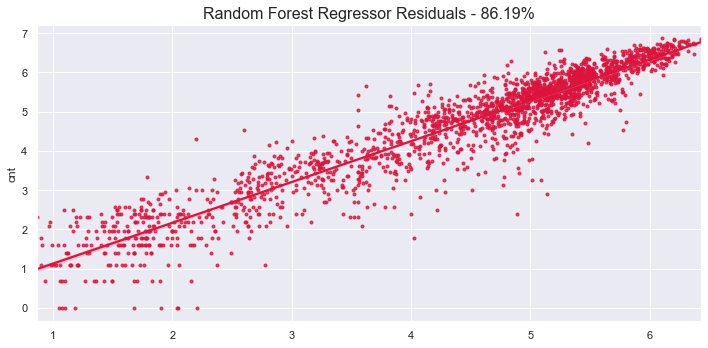

In [54]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(10, 5))

sns.regplot(x=grid_y_hat, y=y_test, color='crimson', marker='.')
ax.set_title(f'Random Forest Regressor Residuals - {100*round(grid_search_score, 4)}%', fontsize=16)



fig.tight_layout()

## Plotting a histogram for the residuals

C:\Users\Niklas\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


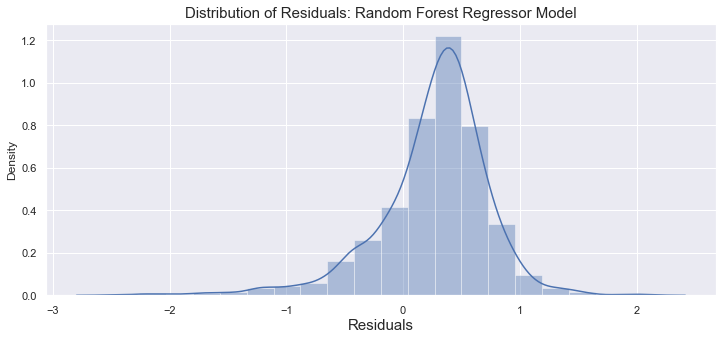

In [55]:
residuals = y_test - grid_y_hat

import seaborn as sns
sns.distplot(residuals, bins = 20) # you may select the no. of bins
plt.title('Distribution of Residuals: Random Forest Regressor Model', fontsize=15)           
plt.xlabel('Residuals', fontsize = 15)     
plt.show()

## Plotting actual vs predicted values

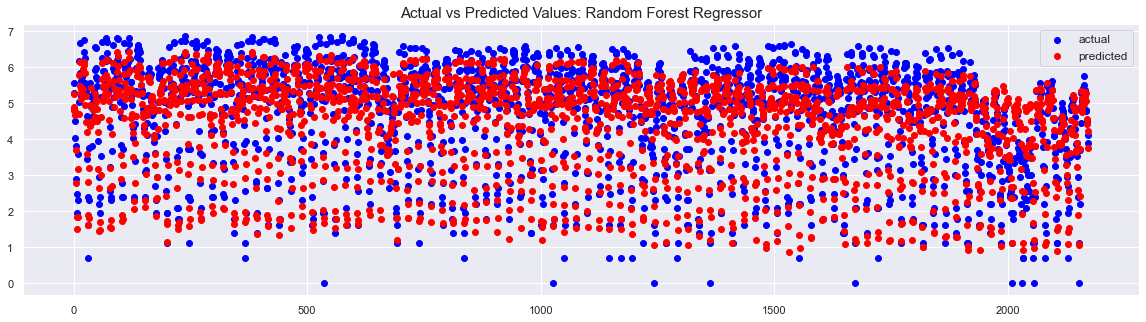

In [56]:
def plotGraph(y_test,grid_y_hat,regressorName):
    if max(y_test) >= max(grid_y_hat):
        my_range = int(max(y_test))
    else:
        my_range = int(max(grid_y_hat))
    plt.figure(figsize=(20,5))
    plt.scatter(range(len(y_test)), y_test, color='blue', label= 'actual')
    plt.scatter(range(len(grid_y_hat)), grid_y_hat, color='red', label= 'predicted')
    plt.legend(fontsize=12)
    plt.title(regressorName, fontsize=15)
    plt.show()
    return

plotGraph(y_test, grid_y_hat, "Actual vs Predicted Values: Random Forest Regressor")

# Model Evolution

Text(0, 0.5, 'mse')

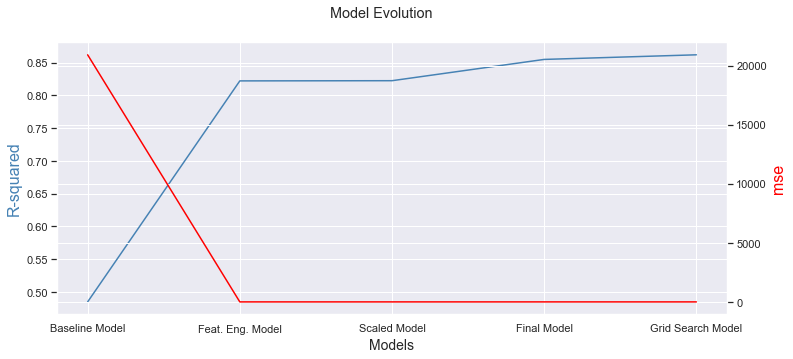

In [57]:
all_models = ["Baseline Model", "Feat. Eng. Model", "Scaled Model", "Final Model", "Grid Search Model" ]
all_r2 = [baseline_model_scores[1]['R-squared'], feature_eng_model_scores[1]['R-squared'], scaled_rf_model_scores[1]['R-squared'], final_model, grid_search_score]
all_mse = [baseline_model_scores[1]['MSE'], feature_eng_model_scores[1]['MSE'], scaled_rf_model_scores[1]['MSE'], final_mse, grid_search_mse]

r2_all = pd.DataFrame({
    "models": all_models,
    "R_squared": all_r2})

mse_all = pd.DataFrame({
    "models": all_models,
    "mse": all_mse})

#define colors to use
col1 = 'steelblue'
col2 = 'red'

#define subplots
fig, ax = plt.subplots()
fig.suptitle("Model Evolution")

#add first line to plot
ax.plot(r2_all.models, r2_all.R_squared, color=col1)

#add x-axis label
ax.set_xlabel('Models', fontsize=14)

#add y-axis label
ax.set_ylabel('R-squared', color=col1, fontsize=16)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

#add second line to plot
ax2.plot(mse_all.models, mse_all.mse, color=col2)

#add second y-axis label
ax2.set_ylabel('mse', color=col2, fontsize=16)